<a href="https://colab.research.google.com/github/shivankgarg98/AE630-control-codes/blob/master/AE630A_final_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 2019 (c) Ahsan Barkati, Shivank Garg
##
 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, sinm, cosm

In [ ]:
class aircraft:
    def __init__(self, mass, I):
        self.mass = mass
        self.I = I
        self.attitude = np.identity(3)
        self.acceleration = np.array([0,0,0])
        self.position = np.array([0,0,0])
        self. velocity = np.array([0,0,0])
        self.omega = np.array([0,0,0])
        self.thrust = 0

In [ ]:
class attitude_controller:
    def __init__(self):
        self.rotation_gain = 10
        self.omega_gain = 0.8
        self.loop_count = 25
        self.dt = 0.01
        self.omega_history = []
        self.attitude_history = []
    def rot_to_eul(self, R):
        if(R[2][0] != 1 and R[2][0] != -1):
            theta1 = -np.arcsin(R[2][0])
            theta2 = np.pi - theta1
            phi1 = np.arctan2(R[2][1] / np.cos(theta1), R[2][2]/np.cos(theta1))
            phi2 = np.arctan2(R[2][1] / np.cos(theta2), R[2][2]/np.cos(theta2))
            shi1 = np.arctan2(R[1][0] / np.cos(theta1), R[0][0]/np.cos(theta1))
            shi2 = np.arctan2(R[1][0] / np.cos(theta2), R[0][0]/np.cos(theta2))
            theta = theta1
            phi = phi1
            shi = shi1
        else:
            phi = 0
            if(R[2][0] == -1):
                theta = np.pi/2
                shi = phi + np.arctan2(R[0][1], R[0][2])
            else:
                theta = -np.pi/2
                shi = -phi + arctan2(-R[0][1], -R[0][2])
        return theta, phi, shi
    def control(self, aircraft, desired_attitude):
        self.aircraft = aircraft
        w_d = np.array([0,0,0])
        for _ in range(self.loop_count):
            
            (self.omega_history).append(aircraft.omega)
            (self.attitude_history).append(self.rot_to_eul(aircraft.attitude))
            error_r = self.get_er(desired_attitude, aircraft.attitude)
            error_w = self.get_ew(desired_attitude, aircraft.attitude, aircraft.omega, w_d)
            moment = self.get_required_moment(error_r, error_w)
            omega_new = self.get_w_new(aircraft.omega, moment)
            R_new = np.matmul(aircraft.attitude, expm(self.hat(omega_new) * self.dt ))
            aircraft.attitude = R_new
            aircraft.omega = omega_new
        
        return aircraft
    def plot_omega_history(self):
        plt.plot(self.omega_history)
        plt.title("attitude control")
        plt.xlabel("Time")
        plt.ylabel("Omega")
    def plot_attitude_history(self):
        plt.plot(self.attitude_history)
        plt.title("attitude control")
        plt.legend(['theta', 'phi', 'shi'])
        plt.xlabel("Time")
        plt.ylabel("Attitude")
        plt.axhline(y=0.2, color='b', linestyle='--')
        plt.axhline(y=0.5, color='r', linestyle='--')
        plt.axhline(y=1.3, color='g', linestyle='--')

        
    def hat(self, vector):
        return np.array([[0,-vector[2], vector[1]], [vector[2], 0, -vector[0]], [-vector[1], vector[0], 0]])
    
    def hat_inv(self, Matrix):
        return np.array([-Matrix[1][2] , Matrix[0][2], -Matrix[0][1]])

    def R_dot(self, R, w_hat):
        return np.matmul(R, w_hat)

    def get_w_new(self, w, moment):
        I = self.aircraft.I
        w_dot = np.matmul(np.linalg.inv(I), moment - np.cross(w,np.matmul(I,w)))
        return w + w_dot*self.dt

    def get_er(self, R_d, R):
        e_hat = np.matmul(R_d.T,R) - np.matmul(R.T, R_d)
        return self.hat_inv(e_hat)
    
    def get_ew(self, R_d, R, w, w_d):
        return w - np.matmul(np.matmul(R_d, R.T), w_d)
    
    def get_required_moment(self, error_r, error_w):
        return -self.rotation_gain*error_r - self.omega_gain*error_w
      
    def eul_to_rot(self, eul):
        theta, phi, shi = eul
        R1 = [np.cos(theta)*np.cos(shi), np.sin(phi)*np.sin(theta)*np.cos(shi)-np.cos(phi)*np.sin(shi), np.cos(phi)*np.sin(theta)*np.cos(shi)+np.sin(phi)*np.sin(shi)]
        R2 = [np.cos(theta)*np.sin(shi), np.sin(phi)*np.sin(theta)*np.sin(shi)+np.cos(phi)*np.cos(shi), np.cos(phi)*np.sin(theta)*np.sin(shi)-np.sin(phi)*np.cos(shi)]
        R3 = [-np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]
        R = np.array([R1, R2, R3])
        return R

In [ ]:
airc = aircraft(mass = 5, I = 0.01*np.identity(3))
att_controller = attitude_controller()
cos = np.cos(np.pi/3)
sin = np.sin(np.pi/3)
Rd = np.array([[cos,-sin,0],[sin, cos, 0], [0,0,1]])

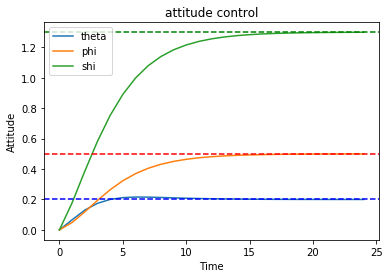

In [ ]:
aircc = att_controller.control(airc,att_controller.eul_to_rot([0.2,0.5,1.3]))
att_controller.plot_attitude_history()

In [ ]:
class position_controller:
    def __init__(self):
        self.loop_count = 100
        self.dt = 0.3
        self.g = 9.8
        self.kp = 0.08
        self.kd = 0.3
        self.velocity_const = 0.1
        self.position_history = []
        self.control_history = []
        self.accn_history = []
        self.accn_d_history = []
        self.vel_history = []
    
    def control(self, aircraft, desired_position):
        self.aircraft = aircraft
        m = aircraft.mass
        for _ in range(self.loop_count):
            position = (self.aircraft).position
            accn_desired = self.desired_accn(position, desired_position)
            
            T_d = self.desired_T(accn_desired)
            phi_d = self.desired_phi(T_d, accn_desired)
            theta_d = self.desired_theta(T_d, phi_d, accn_desired)

            R_d = self.eul_to_rot(theta_d, phi_d, 0)
            attitude_cont = attitude_controller()
            self.aircraft = attitude_cont.control(self.aircraft, R_d)
            new_attitude = self.aircraft.attitude
            aircraft.acceleration = (1/m)*(np.array([0,0,m*self.g]) + np.dot(new_attitude, np.array([0,0,-T_d])))
            aircraft.velocity = aircraft.velocity + aircraft.acceleration*self.dt
            aircraft.position = aircraft.position + aircraft.velocity*self.dt
            
            self.position_history.append(list(aircraft.position))
            self.control_history.append(T_d)
            self.accn_history.append(aircraft.acceleration)
            self.accn_d_history.append(accn_desired)
            self.vel_history.append(aircraft.velocity*np.array([1,1,-1]))
        return self.aircraft

    def desired_T(self, desired_accn):
        accn_x, accn_y, accn_z = desired_accn
        m = self.aircraft.mass
        T_d = m * (accn_x**2 + accn_y**2 + (self.g-accn_z)**2)**0.5
        return T_d
    
    def desired_phi(self, T_d, desired_accn):
        shi_d = 0
        m = self.aircraft.mass
        accn_x, accn_y, accn_z = desired_accn
        num = (-m*accn_x*np.sin(shi_d) + m*accn_y+np.cos(shi_d))
        phi_d = np.arcsin(num/T_d)
        return phi_d
    
    def desired_theta(self, T_d, phi_d, desired_accn):
        m = self.aircraft.mass
        shi_d = 0
        accn_x, accn_y, accn_z = desired_accn
        num = -m*accn_x*np.cos(shi_d) - m*accn_y*np.sin(shi_d)
        theta_d = np.arcsin(num/(T_d*np.cos(phi_d)))
        return theta_d
    
    def eul_to_rot(self, theta, phi, shi):
        R1 = [np.cos(theta)*np.cos(shi), np.sin(phi)*np.sin(theta)*np.cos(shi)-np.cos(phi)*np.sin(shi), np.cos(phi)*np.sin(theta)*np.cos(shi)+np.sin(phi)*np.sin(shi)]
        R2 = [np.cos(theta)*np.sin(shi), np.sin(phi)*np.sin(theta)*np.sin(shi)+np.cos(phi)*np.cos(shi), np.cos(phi)*np.sin(theta)*np.sin(shi)-np.sin(phi)*np.cos(shi)]
        R3 = [-np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]
        R = np.array([R1, R2, R3])
        return R
    
    def desired_velocity(self, X, Xd):
        return self.velocity_const * (X - Xd)
    
    def desired_accn(self, X, X_d):
        V_d = self.desired_velocity(X, X_d)
        return self.kp*(X_d - X) + self.kd*( V_d - self.aircraft.velocity)

In [ ]:
airc = aircraft(mass = 5, I = 0.01*np.identity(3))
airc.position = np.array([10,50,-18])
pos_cont = position_controller()
airc = pos_cont.control(airc, np.array([90,10,60]))

In [ ]:
airc.position

array([90.41885703, 13.81151299, 60.38499346])

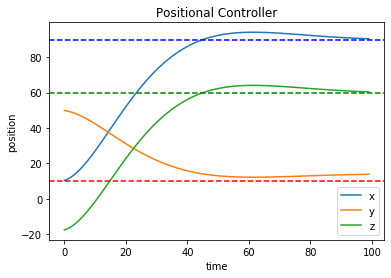

In [ ]:
plt.plot(pos_cont.position_history)
plt.legend(['x','y','z'])
plt.xlabel("time")
plt.ylabel("position")
plt.title("Positional Controller")
plt.axhline(y=90, color='b', linestyle='--')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=60, color='g', linestyle='--')

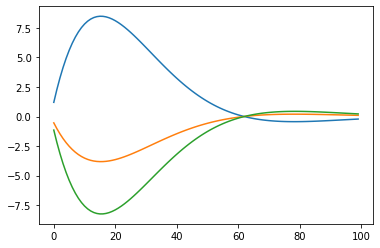

In [ ]:
plt.plot(pos_cont.vel_history)

In [ ]:
ac = attitude_controller()
acn = ac.control(airc, np.identity(3))

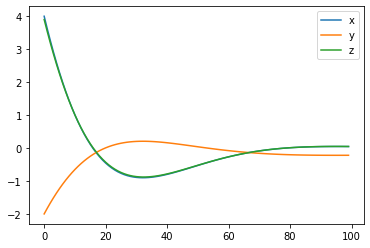

In [ ]:
plt.plot(pos_cont.accn_d_history)
plt.legend(['x','y','z'])

In [ ]:
class TECS_controller:
    def __init__(self, theta = 0, gamma = 0):
        self.loop_count = 20000
        self.dt = 0.01
        self.g = 9.8
        self.alpha = 0
        self.gamma = gamma
        self.T = 0
        self.e1 = 0
        self.e2 = 0
        # energy variables
        self.E_to_T = 12
        self.ki = 0.0005
        self.kd = 0.001
        # energy diff variables
        self.B_to_theta = 0.1
        self.ki2 = 0.01
        self.kd2 = 0.0001
        self.tau_d = 0.001
        self.kh = 0.1
        self.kv = 0.2
        self.integral_h_d = 0
        self.integral_v_d = 0
        self.h_d = 0
        self.v_d = 0
        self.M0 = 5 # DOUBT
        self.alpha0 = 1 # DOUBT
        self.CD0 = 0.000
        self.CL0 = 0.0
        self.CLalpha = 4.695
        self.CDq = 0
        self.CLq = 2.8932
        self.rho = 1.225
        self.qw = 1 # DOUBT
        self.c = 0.5
        self.k = self.CD0*10
        self.S = 1
        self.theta = theta
        self.position_history = []
        self.velocity_history = []
        
    def dynamics(self, control_input, pri):
        c = 0.39
        S = self.S
        k = self.CD0*10 # DOUBT
        M0 = 5 # DOUBT
        alpha0 = 1 # DOUBT
        qw = 1 # DOUBT
        g = self.g
        m = self.aircraft.mass
        v = np.linalg.norm(self.aircraft.velocity)
        h = self.aircraft.position[2]
        
        theta_c, T_c = control_input
        theta_dot = 0.1*(theta_c-self.theta)
        self.theta = self.theta +theta_dot*self.dt
        
        self.alpha = theta_c - self.gamma
        v = np.linalg.norm(self.aircraft.velocity)
        
        CL = self.CoeffLift(self.alpha) + self.CLq*qw*c/(2*v)
        FL = (0.5*self.rho*self.S*v**2)*CL
        FD = self.Drag(v, self.alpha)
        
        v_dot = (1/m)*(T_c*np.cos(self.alpha) - FD - m*g*np.sin(self.gamma))
        gamma_dot = (1/(m*v))*(FL + T_c*np.sin(self.alpha) - m*g*np.cos(self.gamma))
        
        h_dot = v*np.sin(self.gamma)
        h_new = h + h_dot*self.dt
        v_new = v + v_dot*self.dt
        
        self.gamma = self.gamma + gamma_dot*self.dt
        u_new = v_new*np.cos(self.alpha)
        w_new = v_new*np.sin(self.alpha)
        x_new = self.aircraft.position[0] + u_new*self.dt
        self.aircraft.velocity = np.array([u_new, self.aircraft.velocity[1], w_new])
        self.aircraft.position = np.array([x_new,self.aircraft.position[1],h_new])
        self.aircraft.attitude = np.array(self.eul_to_rot([self.theta,0,0]))
        if(pri):
            print("T", T_c)
            print("me", self.aircraft.position)

        
        
        
        
    def control(self, aircraft, height, velocity):
        self.aircraft = aircraft
        for _ in range(self.loop_count):
            pri = 0
            guide = self.guidance([height, velocity])
            T_c = self.control_energy(guide)
            theta_c = self.control_energy_difference(guide)
#             if(_%100 == 0):
#                 print("Tc",T_c, "theta",theta_c)
#                 print("h", self.aircraft.position)
#                 pri = 1
            self.dynamics([theta_c, T_c], pri)
            self.position_history.append(self.aircraft.position)
            self.velocity_history.append(self.aircraft.velocity)
        return self.aircraft
    
    def control_energy(self, guide):
        g = self.g
        h_d, h_d_dot, v_d, v_d_dot = guide
        v = np.linalg.norm(self.aircraft.velocity)
        h = self.aircraft.position[2]
        
        h_dot = v * np.sin(self.gamma)
        v_dot = -g*np.sin(self.gamma) - self.Drag(v, self.alpha) + self.T
        
        gamma_d = h_d_dot/v_d
        gamma = h_dot/v
        
        E = 0.5 * v/g  + h/v
        E_d = 0.5*v_d/g + h_d/v_d
        
        E_dot = v_dot/g + gamma
        E_dot_d = v_d_dot/g + gamma_d
        
        self.e1 += (E_d - E)*self.dt
        delta_T = (self.E_to_T)*(self.ki*self.e1 + (E_d-E) + self.kd*(E_dot_d - E_dot))
        T_c = self.T_lim(self.Drag(v, self.alpha) + delta_T)
        return T_c
    
    def control_energy_difference(self, guide):
        g = self.g
        v = np.linalg.norm(self.aircraft.velocity)
        h_d, h_d_dot, v_d, v_d_dot = guide
        h_dot = v * np.sin(self.gamma)
        v_dot = -g*np.sin(self.gamma) - self.Drag(v, self.alpha) + self.T
        
        h = self.aircraft.position[2]
        
        gamma_d = h_d_dot/(v_d)
        gamma = h_dot/v

        E2 = -0.5*v/g + h/v
        E2_d = -0.5*v_d/g + h_d/v_d

        E2_dot = -v_dot/g + gamma
        E2_dot_d = -v_d_dot/g + gamma_d
        
        self.e2 += (E2_d - E2)*self.dt
        theta_c = self.B_to_theta*(self.ki2 * self.e2 + (E2_d - E2) + self.kd2*(E2_dot_d - E2_dot) + E2_dot_d*self.tau_d)
        theta_c = self.theta_lim(theta_c)
        return theta_c
    
    def guidance(self, command_input):
        v = np.linalg.norm(self.aircraft.velocity)
        h = self.aircraft.position[2]
        
        h_c, v_c = command_input
        
        h_d_dot = self.kh*(h_c - self.h_d)
        v_d_dot = self.kv*(v_c - self.v_d)
        self.integral_h_d += h_d_dot*self.dt
        self.integral_v_d += v_d_dot*self.dt
        self.h_d = self.integral_h_d
        self.v_d = self.integral_v_d
        return (self.h_d, h_d_dot, self.v_d, v_d_dot)
    
    
    def Drag(self, v, alpha):
        CL = self.CoeffLift(alpha) + self.CLq*self.qw*self.c/(2*v)
        CD = self.CD0 + self.k*CL*CL
        return (0.5*self.rho*self.S*v**2)*CD
    
    def T_lim(self, T):
        if ( T < 0):
            return 0
        return min(1000,T)
    
    def theta_lim(self, theta):
        return np.sign(theta)*(min(abs(theta),0.5))

    def sigmoid(self,alpha):
        # transition rate: M0
        a = np.exp(-self.M0 * (alpha - self.alpha0))
        b = np.exp(self.M0 * (alpha + self.alpha0))
        return (1 + a + b)/((1 + a) * (1 + b))
    
    def CoeffLift(self,a):
        s = self.sigmoid(a)
        return (1-s)*(self.CL0+self.CLalpha*a)+s*(2*np.sign(a)*np.sin(a)*np.sin(a)*np.cos(a))
    def rot_to_eul(self, R):
        if(R[2][0] != 1 and R[2][0] != -1):
            theta1 = -np.arcsin(R[2][0])
            theta2 = np.pi - theta1
            phi1 = np.arctan2(R[2][1] / np.cos(theta1), R[2][2]/np.cos(theta1))
            phi2 = np.arctan2(R[2][1] / np.cos(theta2), R[2][2]/np.cos(theta2))
            shi1 = np.arctan2(R[1][0] / np.cos(theta1), R[0][0]/np.cos(theta1))
            shi2 = np.arctan2(R[1][0] / np.cos(theta2), R[0][0]/np.cos(theta2))
            theta = theta1
            phi = phi1
            shi = shi1
        else:
            phi = 0
            if(R[2][0] == -1):
                theta = np.pi/2
                shi = phi + np.arctan2(R[0][1], R[0][2])
            else:
                theta = -np.pi/2
                shi = -phi + arctan2(-R[0][1], -R[0][2])
        return theta, phi, shi
    def eul_to_rot(self, eul):
        theta, phi, shi = eul
        R1 = [np.cos(theta)*np.cos(shi), np.sin(phi)*np.sin(theta)*np.cos(shi)-np.cos(phi)*np.sin(shi), np.cos(phi)*np.sin(theta)*np.cos(shi)+np.sin(phi)*np.sin(shi)]
        R2 = [np.cos(theta)*np.sin(shi), np.sin(phi)*np.sin(theta)*np.sin(shi)+np.cos(phi)*np.cos(shi), np.cos(phi)*np.sin(theta)*np.sin(shi)-np.sin(phi)*np.cos(shi)]
        R3 = [-np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]
        R = np.array([R1, R2, R3])
        return R

In [ ]:
tc = TECS_controller()
airc = aircraft(mass = 5, I = 0.01*np.identity(3))
airc.position = np.array([ 0.1,0 ,180])
airc.velocity = np.array([40, 0.1 ,0])

In [ ]:
res = tc.control(aircraft = airc, height = 320, velocity = 60)

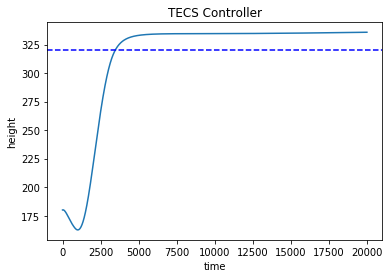

In [ ]:
plt.plot(np.array(tc.position_history)[:,2])
plt.xlabel("time")
plt.ylabel("height")
plt.title("TECS Controller")
plt.axhline(y=320, color='b', linestyle='--')

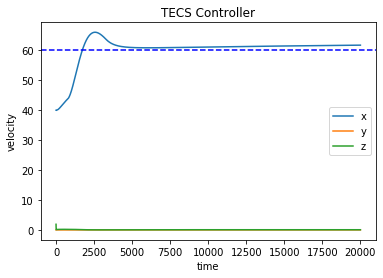

In [ ]:
plt.plot(tc.velocity_history)
plt.legend(['x', 'y', 'z'])
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("TECS Controller")
plt.axhline(y=60, color='b', linestyle='--')

In [ ]:
tc.T

0

In [ ]:
res.velocity

array([61.58483616,  0.1       ,  0.15863262])

In [ ]:
res.position

array([12039.42690866,     0.        ,   335.74625958])

In [ ]:
class transition_controller:
    def __init__(self):
        self.a = 0
        self.v_cruise = 60
        self.h_cruise = 320
        self.stall = 25*np.pi / 180
        self.gamma_d = 0.003198630453473968
        self.level_history = []
        self.vel_history = []
    
    def control(self, aircraft):
        self.aircraft = aircraft
        self.init_euler = self.rot_to_eul(aircraft.attitude)
        self.desired_euler = np.array([-np.pi/2,self.init_euler[1],self.init_euler[2]])
        self.theta_inter = self.stall + self.gamma_d - np.pi/2
        self.inter_euler = np.array([self.theta_inter,self.init_euler[1],self.init_euler[2] ])
        at_cont = attitude_controller()
        R_inter = self.eul_to_rot(self.inter_euler)
        self.aircraft = at_cont.control(aircraft,R_inter)
        self.aircraft.position = self.aircraft.position * np.array([1,1,-1])
        #self.aircraft.velocity = np.array([30,0,0])

        # intermediate achieved
        theta_int = np.pi/2 - abs(self.theta_inter)
        level_cont = TECS_controller(theta = theta_int)
        self.aircraft = level_cont.control(self.aircraft, self.h_cruise, self.v_cruise)
        self.level_history = np.array(level_cont.position_history)[:,2]
        self.vel_history = np.array(level_cont.velocity_history)
        #plt.plot(np.array(level_cont.position_history)[:,2])
        return self.aircraft
        
    def rot_to_eul(self, R):
        if(R[2][0] != 1 and R[2][0] != -1):
            theta1 = -np.arcsin(R[2][0])
            theta2 = np.pi - theta1
            phi1 = np.arctan2(R[2][1] / np.cos(theta1), R[2][2]/np.cos(theta1))
            phi2 = np.arctan2(R[2][1] / np.cos(theta2), R[2][2]/np.cos(theta2))
            shi1 = np.arctan2(R[1][0] / np.cos(theta1), R[0][0]/np.cos(theta1))
            shi2 = np.arctan2(R[1][0] / np.cos(theta2), R[0][0]/np.cos(theta2))
            theta = theta1
            phi = phi1
            shi = shi1
        else:
            phi = 0
            if(R[2][0] == -1):
                theta = np.pi/2
                shi = phi + np.arctan2(R[0][1], R[0][2])
            else:
                theta = -np.pi/2
                shi = -phi + arctan2(-R[0][1], -R[0][2])
        return theta, phi, shi
    def eul_to_rot(self, eul):
        theta, phi, shi = eul
        R1 = [np.cos(theta)*np.cos(shi), np.sin(phi)*np.sin(theta)*np.cos(shi)-np.cos(phi)*np.sin(shi), np.cos(phi)*np.sin(theta)*np.cos(shi)+np.sin(phi)*np.sin(shi)]
        R2 = [np.cos(theta)*np.sin(shi), np.sin(phi)*np.sin(theta)*np.sin(shi)+np.cos(phi)*np.cos(shi), np.cos(phi)*np.sin(theta)*np.sin(shi)-np.sin(phi)*np.cos(shi)]
        R3 = [-np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]
        R = np.array([R1, R2, R3])
        return R
    

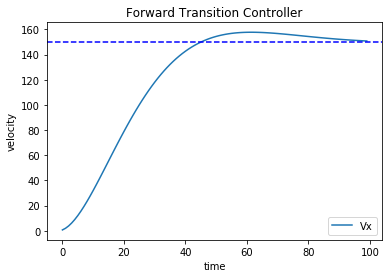

In [ ]:
airc = aircraft(mass = 5, I = 0.01*np.identity(3))
airc.omega = np.array([0,0,0])
airc.position = np.array([0,0,0])
pos_cont = position_controller()

airc = pos_cont.control(airc, np.array([0,0,-150]))
trans = transition_controller()
res = trans.control(airc)

plt.plot(np.array(pos_cont.position_history)[:,2]*-1)
plt.legend(['Vx', 'Vy', 'Vz'])
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("Forward Transition Controller")
plt.axhline(y=150, color='b', linestyle='--')

In [ ]:
class back_transition:
    def __init__(self):
        self.integral_h_d = 0
        self.integral_v_d = 0
        self.h_d = 0
        self.v_d = 0
        self.M0 = 5 # DOUBT
        self.alpha0 = 1 # DOUBT
        self.CD0 = 0.000
        self.CL0 = 0.0
        self.CLalpha = 4.695
        self.CDq = 0
        self.CLq = 2.8932
        self.rho = 1.225
        self.qw = 1 # DOUBT
        self.c = 0.5
        self.k = self.CD0*10
        self.S = 1
        self.position_history = []
        self.velocity_history = []
        self.g = 9.8
        self.theta = 0
        self.dt = 0.01
        self.gamma = 0
    
    def dynamics(self, control_input, pri):
        c = 0.39
        S = self.S
        k = self.CD0*10 # DOUBT
        M0 = 5 # DOUBT
        alpha0 = 1 # DOUBT
        qw = 1 # DOUBT
        g = self.g
        m = self.aircraft.mass
        
        v = np.linalg.norm(self.aircraft.velocity)
        h = self.aircraft.position[2]
        
        theta_c, T_c = control_input
        theta_dot = 0.1*(theta_c-self.theta)
        self.theta = self.theta +theta_dot*self.dt
        
        self.alpha = theta_c - self.gamma
        v = np.linalg.norm(self.aircraft.velocity)
        
        CL = self.CoeffLift(self.alpha) + self.CLq*qw*c/(2*v)
        FL = (0.5*self.rho*self.S*v**2)*CL
        FD = self.Drag(v, self.alpha)
        
        v_dot = (1/m)*(T_c*np.cos(self.alpha) - FD - m*g*np.sin(self.gamma))
        gamma_dot = (1/(m*v))*(FL + T_c*np.sin(self.alpha) - m*g*np.cos(self.gamma))
        
        h_dot = v*np.sin(self.gamma)
        h_new = h + h_dot*self.dt
        v_new = v + v_dot*self.dt
        
        self.gamma = self.gamma + gamma_dot*self.dt
        u_new = v_new*np.cos(self.alpha)
        w_new = v_new*np.sin(self.alpha)
        x_new = self.aircraft.position[0] + u_new*self.dt
        self.aircraft.velocity = np.array([u_new, self.aircraft.velocity[1], w_new])
        self.aircraft.position = np.array([x_new,self.aircraft.position[1],h_new])
        self.aircraft.attitude = np.array(self.eul_to_rot([self.theta,0,0]))
        if(pri):
            print("unew", u_new, "w_new", w_new, "h_new", h_new)
            print("me", self.aircraft.position)
        
    def control(self, aircraft):
        self.aircraft = aircraft
        print(self.aircraft.position)
        print(self.aircraft.velocity)
        print(self.rot_to_eul(self.aircraft.attitude))
        theta = self.rot_to_eul(self.aircraft.attitude)[0]
        
        for _ in range(1000):
            theta_c = 0.3*(np.pi/2 - theta)**2
            self.dynamics([theta_c, 0],0)
            self.position_history.append(self.aircraft.position)
            self.velocity_history.append(self.aircraft.velocity)
        return self.aircraft

    def rot_to_eul(self, R):
        if(R[2][0] != 1 and R[2][0] != -1):
            theta1 = -np.arcsin(R[2][0])
            theta2 = np.pi - theta1
            phi1 = np.arctan2(R[2][1] / np.cos(theta1), R[2][2]/np.cos(theta1))
            phi2 = np.arctan2(R[2][1] / np.cos(theta2), R[2][2]/np.cos(theta2))
            shi1 = np.arctan2(R[1][0] / np.cos(theta1), R[0][0]/np.cos(theta1))
            shi2 = np.arctan2(R[1][0] / np.cos(theta2), R[0][0]/np.cos(theta2))
            theta = theta1
            phi = phi1
            shi = shi1
        else:
            phi = 0
            if(R[2][0] == -1):
                theta = np.pi/2
                shi = phi + np.arctan2(R[0][1], R[0][2])
            else:
                theta = -np.pi/2
                shi = -phi + arctan2(-R[0][1], -R[0][2])
        return theta, phi, shi
    def Drag(self, v, alpha):
        CL = self.CoeffLift(alpha) + self.CLq*self.qw*self.c/(2*v)
        CD = self.CD0 + self.k*CL*CL
        return (0.5*self.rho*self.S*v**2)*CD

    def T_lim(self, T):
        if ( T < 0):
            return 0
        return min(1000,T)
    
    def theta_lim(self, theta):
        return np.sign(theta)*(min(abs(theta),0.5))

    def sigmoid(self,alpha):
        # transition rate: M0
        a = np.exp(-self.M0 * (alpha - self.alpha0))
        b = np.exp(self.M0 * (alpha + self.alpha0))
        return (1 + a + b)/((1 + a) * (1 + b))
    
    def CoeffLift(self,a):
        s = self.sigmoid(a)
        return (1-s)*(self.CL0+self.CLalpha*a)+s*(2*np.sign(a)*np.sin(a)*np.sin(a)*np.cos(a))
    def eul_to_rot(self, eul):
        theta, phi, shi = eul
        R1 = [np.cos(theta)*np.cos(shi), np.sin(phi)*np.sin(theta)*np.cos(shi)-np.cos(phi)*np.sin(shi), np.cos(phi)*np.sin(theta)*np.cos(shi)+np.sin(phi)*np.sin(shi)]
        R2 = [np.cos(theta)*np.sin(shi), np.sin(phi)*np.sin(theta)*np.sin(shi)+np.cos(phi)*np.cos(shi), np.cos(phi)*np.sin(theta)*np.sin(shi)-np.sin(phi)*np.cos(shi)]
        R3 = [-np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]
        R = np.array([R1, R2, R3])
        return R

[1.27451119e+04 4.02094329e+00 3.58518679e+02]
[ 6.49024423e+01 -1.08393266e-02  1.44291344e-01]
(0.0025226414628629714, 0.0, 0.0)


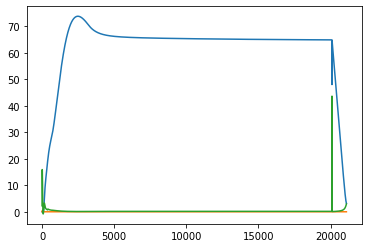

In [ ]:
airc = aircraft(mass = 5, I = 0.01*np.identity(3))
airc.omega = np.array([0,0,0])
airc.position = np.array([0,0,0])
pos_cont = position_controller()
airc = pos_cont.control(airc, np.array([0,0,-150]))

trans = transition_controller()
res = trans.control(airc)
bt = back_transition()
nw = bt.control(res)
#plt.plot(np.array(bt.position_history)[:,2])

pos_cont2 = position_controller()
res2 = pos_cont2.control(nw, np.array([0,0,0]))

history = []
history += list(np.array(pos_cont.position_history)[:,2]*-1)
history += list(trans.level_history)
history += list(np.array(bt.position_history)[:,2])
history += list(np.array(pos_cont2.position_history)[:,2])

vel_history = []
vel_history += list(np.array(pos_cont.vel_history))
vel_history += list(np.array(trans.vel_history))
vel_history += list(np.array(bt.velocity_history))
plt.plot(vel_history)

Text(0.5, 1.0, 'Overall Simulation')

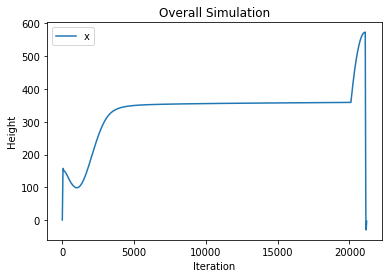

In [ ]:
plt.plot(history)
plt.legend(['x', 'y', 'z'])
plt.xlabel("Iteration")
plt.ylabel("Height")
plt.title("Overall Simulation")

Text(0.5, 1.0, 'Overall Simulation')

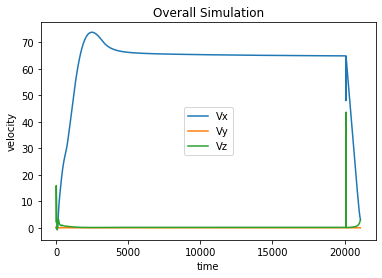

In [ ]:
plt.plot(vel_history)
plt.legend(['Vx', 'Vy', 'Vz'])
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("Overall Simulation")